<a href="https://colab.research.google.com/github/xygxue/TimeGAN/blob/master/Final_Assignment_Yuge_Xue_2022_06_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Yuge Xue**

https://colab.research.google.com/drive/1FrfVw6T5HZ7AKppFVBk9pqtXxAWP9-WR?usp=sharing

**Assignment Description:** In this assignment I will create a Machine Learning(ML) Pipeline for the task - 
[Classify images of clothing](https://www.tensorflow.org/tutorials/keras/classification) using TensorFlow Extended(TFX).



### Pipeline Overview
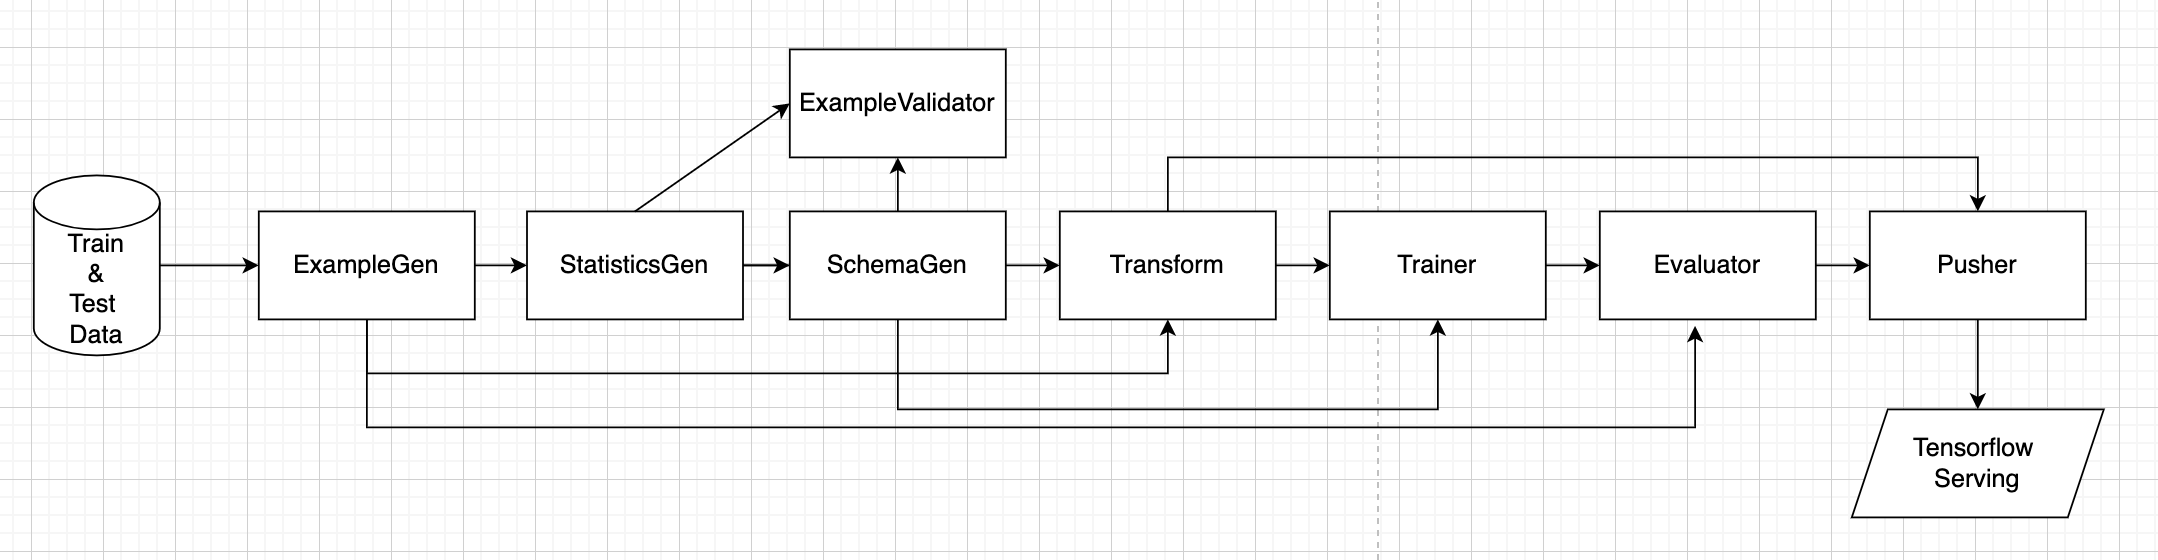

In [ ]:
!pip install tfx
!pip install grpcio
!pip install packaging
!pip install protobuf
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 7.0 MB/s 
     |████████████████████████████████| 19.2 MB 163 kB/s 
     |████████████████████████████████| 135 kB 48.4 MB/s 
     |████████████████████████████████| 1.8 MB 45.9 MB/s 
     |████████████████████████████████| 1.3 MB 13.1 MB/s 
     |████████████████████████████████| 1.8 MB 45.1 MB/s 
     |████████████████████████████████| 40 kB 3.0 MB/s 
     |████████████████████████████████| 1.4 MB 54.1 MB/s 
     |████████████████████████████████| 206 kB 34.4 MB/s 
     |████████████████████████████████| 6.6 MB 35.7 MB/s 
     |████████████████████████████████| 147 kB 19.6 MB/s 
     |████████████████████████████████| 1.7 MB 18.0 MB/s 
     |████████████████████████████████| 133 kB 48.6 MB/s 
     |████████████████████████████████| 23.6 MB 61.7 MB/s 
     |████████████████████████████████| 49 kB 3.1 MB/s 
     |█████████████████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Please Restart Runtime**

Restart the runtime if you are running the cell above for the first time, as the module installed using `!pip install` is not included in colab's module registry except after a runtime restart. If you import a different version of this installed package, please also restart runtime.

**How to:** Click "RESTART RUNTIME" in the installation logs or using "Runtime > Restart
runtime" option.


In [ ]:
import os

import absl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tfx.components import ImportExampleGen, StatisticsGen, SchemaGen, \
    ExampleValidator, Pusher, Trainer, Transform, \
    Evaluator
from tfx.orchestration import metadata
from tfx.orchestration import pipeline
from tfx.orchestration.beam.beam_dag_runner import BeamDagRunner
from tfx.proto import example_gen_pb2
from tfx.proto import pusher_pb2
from tfx.proto import trainer_pb2
from tfx.types import Channel
from tfx.types.standard_artifacts import Model
from tfx.types.standard_artifacts import ModelBlessing

import tfx

In [ ]:
print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.8.2
TFX version: 1.8.0


In [ ]:
# remove the previously created pipeline module
!rm -rf *trainer.py
!rm -rf transform.py
!sudo rm -r /content/tfx

rm: cannot remove '/content/tfx': No such file or directory


In [ ]:
# create directories needed
! cd /content/
! mkdir /content/tfx/
! mkdir /content/tfx/pipelines
! mkdir /content/tfx/metadata
! mkdir /content/tfx/logs
! mkdir /content/tfx/data
! mkdir /content/tfx/model_dir

In [ ]:
# define global variables
tfx_root = os.path.join(os.getcwd(), 'tfx')     
PIPELINE_PATH = os.path.join(tfx_root, 'pipelines')  
PIPELINE_NAME = 'fashion_mnist'
METADATA_PATH = os.path.join(tfx_root, 'metadata.db')
LOG_PATH = os.path.join(tfx_root, 'logs')
MODEL_PATH = os.path.join(tfx_root, 'model')
DATA_DIR = os.path.join(tfx_root, 'data')
MODEL_SERVE_PATH = os.path.join(tfx_root, 'model_dir')
METADATA_PATH = os.path.join(tfx_root, 'metadata', PIPELINE_NAME,
                              'metadata.db')
_TRAIN_STEPS = 5000
_EVAL_STEPS = 1000

_transform_module_file = 'transform.py'
_inputfn_module_file = 'util.py'
_model_trainer_module_file = 'model_trainer.py'

## Load Dataset

The dataset we are using is [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) from Zalando. Among the 70,000 grayscale images it contains, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. TensorFlow allows us to access the Fashion MNIST directly from `tf.keras.datasets`.

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
print("Training data shape: ", train_images.shape)
print("Training label shape: ", train_labels.shape)
print("Testing data shape: ", test_images.shape)
print("Testing label shape: ", test_labels.shape)

Training data shape:  (60000, 28, 28)
Training label shape:  (60000,)
Testing data shape:  (10000, 28, 28)
Testing label shape:  (10000,)


The data is categorized into 10 classes, we store the name of these categories here to use later when plotting the images.




In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Convert Dataset to TFRecords

As ExampleGen only supports CSV files, TFRecord files and results of BigQuery queries, we need to convert the downloaded dataset in **numpy.ndarray** to **TFRecords**. Each record in the original dataset will be converted to a `tf.train.Example` message, then written to `.tfrecords` file. 

### *What is tf.train.Example?*

According to [TFRecord documentation](https://www.tensorflow.org/tutorials/load_data/tfrecord), "a `tf.train.Example` is a `{"string": tf.train.Feature} ` mapping." 

In TensorFlow, the **tf.train.Example** class represents the protocol buffer used to store data for the input pipeline. [Protocol buffers](https://developers.google.com/protocol-buffers/) are developed by Google that use a structured format for serializing structured data. 

### *How to create tf.train.Example?*

Below [TFRecord documentation](https://www.tensorflow.org/tutorials/load_data/tfrecord) shows us how to create a `tf.train.Example` message:

    1. Within each observation, each value needs to be converted to a tf.train.Feature containing one of the 3 compatible types, using one of the functions above.

    2. You create a map (dictionary) from the feature name string to the encoded feature value produced in #1.

    3. The map produced in step 2 is converted to a Features message.

In our case, in Step 1, we can convert the image to `tf.train.BytesList` and label to `tf.train.Int64List`. But since `tf.train.BytesList` doesn't accept numpy.ndarray image data input, we can first serialize the data into a `tf.Tensor` of type `tf.string` containing the image data in a binary string format, then convert the binary-string to `tf.train.BytesList`.

### *Now, we can create a TFRecordfile!*

After Step 3, we initialize a tf.train.Example object and set features argument to a tf.train.Features object. The tf.train.Features class is initialized by setting the feature field to a dictionary that maps feature names to feature values in Step 2.

In the end, all proto messages can be serialized to a binary-string using the `.SerializeToString` method and then be written into `.tfrecords` file.

In [ ]:
def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def convert_to_tfrecords(images, labels , name, data_dir):
  """Converts a TF dataset to tfrecords."""
  num_examples = images.shape[0]
  rows = images.shape[1]
  cols = images.shape[2]

  split_dir = os.path.join(data_dir, name)
  if not os.path.isdir(split_dir):
    os.makedirs(split_dir)
  filename = os.path.join(split_dir, name + '.tfrecords')

  print('Writing', filename)
  with tf.io.TFRecordWriter(filename) as writer:
    for index in range(num_examples):
        image_raw = tf.io.serialize_tensor(images[index])
        feature={
                'label': _int64_feature(int(labels[index])),
                'image': _bytes_feature(image_raw)
                }
        features=tf.train.Features(feature=feature)
        example = tf.train.Example(features=features)
        writer.write(example.SerializeToString())

In [ ]:
# Convert to Examples and write the result to TFRecord files.
convert_to_tfrecords(train_images, train_labels, 'train', DATA_DIR)
convert_to_tfrecords(test_images, test_labels, 'test', DATA_DIR)

Writing /content/tfx/data/train/train.tfrecords
Writing /content/tfx/data/test/test.tfrecords


## ExampleGen (Train - Test Split)
ExampleGen takes the TFRecords to generate Examples which will be read by other TFX components. As we saved the training input and testing input under two TFRecords, so to specify the file which reads the train/test data, we define glob relative file pattern in `input_config`.

In [ ]:
# Input train split path is 'input_dir/train/*', eval split path is 'input_dir/eval/*'.
input_config = example_gen_pb2.Input(splits=[
    example_gen_pb2.Input.Split(name='train', pattern='train/*'),
    example_gen_pb2.Input.Split(name='eval', pattern='test/*')
])

# Brings data into the pipeline.
example_gen = ImportExampleGen(
    input_base=DATA_DIR, input_config=input_config)

## StatisticsGen
By [definition](https://www.tensorflow.org/tfx/guide/statsgen), StatisticsGen generates features statistics over both training and serving data, which can be used by other pipeline components. 

In [ ]:
statistics_gen = StatisticsGen(examples=example_gen.outputs['examples'])

schema_gen = SchemaGen(
      statistics=statistics_gen.outputs['statistics'], 
      infer_feature_shape=True)

INFO:absl:Excluding no splits because exclude_splits is not set.
INFO:absl:Excluding no splits because exclude_splits is not set.


## ExampleValidator
By [definition](https://hwww.tensorflow.org/tfx/guide/exampleval), ExampleValidator identifies anomalies in training and serving data. It takes a schema from a SchemaGen component, and statistics from a StatisticsGen component.

In [ ]:
validate_stats = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'])

INFO:absl:Excluding no splits because exclude_splits is not set.


## Transform the Data

By [definition](https://www.tensorflow.org/tfx/guide/transform)Transform TFX pipeline component performs feature engineering on tf.Examples emitted from an ExampleGen component, using a data schema created by a SchemaGen component, and emits both a SavedModel as well as statistics on both pre-transform and post-transform data. 

Transform components will take a python module that contains the function named `preprocessing_fn`. In this function, we write the preprocessing step needed to transform our data.

Here in `preprocessing_fn`, we used inverse operation of `tf.io.serialize_tensor` (which was used earilier to serialize the tensor in converting data to TFRecords) that transforms a scalar string containing a serialized Tensor into a Tensor of a specified type.

In [ ]:
%%writefile {_transform_module_file}
import tensorflow as tf
import tensorflow_transform as tft

IMAGE_KEY = 'image'
LABEL_KEY = 'label'

# in order to differentiate the transformed features with the original feature, 
# we add a suffix to the feature name
def transformed_name(key):
    return key + '_xf'

def preprocessing_fn(inputs):
    """tf.transform's callback function for preprocessing inputs.

    Args:
      inputs: map from feature keys to raw not-yet-transformed features.

    Returns:
      Map from string feature key to transformed feature operations.
    """

    outputs = {}
    # following code is adapted from 
    # https://stackoverflow.com/questions/72166920/image-processing-in-tensor-flow-tfx-pipelines/72256550
    raw_image_dataset = tf.map_fn(fn=lambda x : tf.io.parse_tensor(x[0], tf.uint8, name=None), 
                                  elems=inputs[IMAGE_KEY], 
                                  fn_output_signature=tf.TensorSpec((28,28),dtype=tf.uint8,name=None), 
                                  infer_shape = True)

    # in classification tutorial, the feature was scaled to 0 and 1 using direct 
    # division by 255, here for tensor operation we use 'scale_to_0_1' from tensorflow_transform
    image_dataset = tft.scale_to_0_1(raw_image_dataset)
    outputs[transformed_name(IMAGE_KEY)] = image_dataset

    outputs[transformed_name(LABEL_KEY)] = inputs[LABEL_KEY]
    return outputs

Overwriting transform.py


In [ ]:
transform = tfx.components.Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=os.path.abspath(_transform_module_file))

## Train the Model
By [definition](https://www.tensorflow.org/tfx/guide/trainer), the Trainer TFX pipeline component trains a TensorFlow model. 

Similar to Transformer, Trainer needs a python module, `run_fn`, that creates, trains and save the model. In our case, trainer takes the following input:
1. tf.Examples used for training and eval, which are given by the output from Transform component.
2. A user provided module file that defines the trainer logic that contains `run_fn`.
3. Protobuf definition of train args and eval args.
4. A data schema created by a SchemaGen pipeline component and optionally altered by the developer.
5. Transform graph produced by an upstream Transform component.

In [ ]:
%%writefile {_model_trainer_module_file}

import absl

import tensorflow as tf
import tensorflow_transform as tft
from tfx.components.trainer.fn_args_utils import FnArgs
from tfx_bsl.tfxio import dataset_options

IMAGE_KEY = 'image'
LABEL_KEY = 'label'

_TRAIN_BATCH_SIZE = 40
_EVAL_BATCH_SIZE = 20


def transformed_name(key):
  """Add suffix to the feature name."""
    return key + '_xf'

# _build_keras_model is using the model defined in the classification tutorial:
# https://www.tensorflow.org/tutorials/keras/classification
def _build_keras_model():
  """Creates a DNN Keras model for classifying fashion mnist data.

  Returns:
    A Keras Model.
  """
  # add InputLayer to feed the data in the model, the input layer's name should 
  # match training data's label 
  model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28), name=transformed_name(IMAGE_KEY)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
    ])
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['sparse_categorical_accuracy'])
  model.summary(print_fn=absl.logging.info)
  return model


# the following code is adapted from: 
# https://github.com/tensorflow/tfx/blob/master/tfx/examples/mnist/mnist_utils_native_keras.py

def input_fn(file_pattern,
             data_accessor,
             tf_transform_output,
             batch_size: int = 200) -> tf.data.Dataset:
  """Generates features and label for tuning/training.
  Args:
    file_pattern: List of paths or patterns of input tfrecord files.
    data_accessor: DataAccessor for converting input to RecordBatch.
    tf_transform_output: A TFTransformOutput.
    batch_size: representing the number of consecutive elements of returned
      dataset to combine in a single batch
  Returns:
    A dataset that contains (features, indices) tuple where features is a
      dictionary of Tensors, and indices is a single Tensor of label indices.
  """
  return data_accessor.tf_dataset_factory(
      file_pattern,
      dataset_options.TensorFlowDatasetOptions(
          batch_size=batch_size, label_key=transformed_name(LABEL_KEY)),
      tf_transform_output.transformed_metadata.schema).repeat()


def _get_serve_tf_examples_fn(model, tf_transform_output):
  """Returns a function that parses a serialized tf.Example."""

  model.tft_layer = tf_transform_output.transform_features_layer()

  @tf.function
  def serve_tf_examples_fn(serialized_tf_examples):
    """Returns the output to be used in the serving signature."""
    feature_spec = tf_transform_output.raw_feature_spec()
    feature_spec.pop(LABEL_KEY)
    parsed_features = tf.io.parse_example(serialized_tf_examples, feature_spec)
    transformed_features = model.tft_layer(parsed_features)

    return model(transformed_features)

  return serve_tf_examples_fn


# As Trainer uses GenericExecutor, 'run_fn' must be supplied
def run_fn(fn_args: FnArgs):
  """Train the model based on given args.
  Args:
    fn_args: Holds args used to train the model as name/value pairs.
  """
  tf_transform_output = tft.TFTransformOutput(fn_args.transform_output)
  
  train_dataset = input_fn(fn_args.train_files, fn_args.data_accessor,
                                tf_transform_output, _TRAIN_BATCH_SIZE)
  eval_dataset = input_fn(fn_args.eval_files, fn_args.data_accessor,
                               tf_transform_output, _EVAL_BATCH_SIZE)

  # Set up models
  mirrored_strategy = tf.distribute.MirroredStrategy()
  with mirrored_strategy.scope():
      model = _build_keras_model()

  # Write logs to path
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=fn_args.model_run_dir, update_freq='batch')

  # Train the models
  model.fit(
      train_dataset,
      steps_per_epoch=fn_args.train_steps,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps,
      callbacks=[tensorboard_callback])

  signatures = {
      'serving_default':
          _get_serve_tf_examples_fn(
              model, tf_transform_output).get_concrete_function(
                  tf.TensorSpec(shape=[None], dtype=tf.string, name='examples'))
  }
  model.save(fn_args.serving_model_dir, save_format='tf', signatures=signatures)

Overwriting model_trainer.py


In [ ]:
def _create_trainer(module_file, component_id):
  return Trainer(
      module_file=module_file,
      examples=transform.outputs['transformed_examples'],
      transform_graph=transform.outputs['transform_graph'],
      schema=schema_gen.outputs['schema'],
      train_args=trainer_pb2.TrainArgs(num_steps=_TRAIN_STEPS),
      eval_args=trainer_pb2.EvalArgs(num_steps=_EVAL_STEPS)).with_id(component_id)

In [ ]:
# train the model with the module we created before
trainer = _create_trainer(_model_trainer_module_file, 'Trainer.mnist')

## Evaluator
By [definition](https://www.tensorflow.org/tfx/guide/evaluator), Evaluator TFX pipeline component performs deep analysis on the training results for your models, to help you understand how your model performs on subsets of your data. 

Here we only need to configure slicing_specs and metrics_specs. Besides, here we define that if the new trained model's accuracy is over **80%**, the model will be marked as "good" by the Evaluator and the downstream component "Pusher" will push the model to production.

In [ ]:
import tensorflow_model_analysis as tfma

eval_config = tfma.EvalConfig(
    model_specs=[tfma.ModelSpec(label_key='label')],
    slicing_specs=[tfma.SlicingSpec()],
    metrics_specs=[
        tfma.MetricsSpec(metrics=[
            tfma.MetricConfig(
                class_name='SparseCategoricalAccuracy',
                threshold=tfma.MetricThreshold(
                    value_threshold=tfma.GenericValueThreshold(
                        lower_bound={'value': 0.8})))
        ])
    ])

# Uses TFMA to compute the evaluation statistics over features of a model.
evaluator = Evaluator(
    examples=example_gen.outputs['examples'],
    model=trainer.outputs['model'],
    eval_config=eval_config).with_id('Evaluator.mnist')

## Pusher
By [definition](https://www.tensorflow.org/tfx/guide/pusher), Pusher component is used to push a validated model to a deployment target during model training or re-training. Once there are more than one model is bless(good enough), Pusher will push the model to production. Here we push the model to the model directory `MODEL_SERVE_PATH`.

In [ ]:
pusher = Pusher(
    model=trainer.outputs['model'],
    model_blessing=evaluator.outputs['blessing'],
    push_destination=pusher_pb2.PushDestination(
        filesystem=pusher_pb2.PushDestination.Filesystem(
            base_directory=MODEL_SERVE_PATH))).with_id('Pusher.mnist')

## Pipeline Components All-in-One - Orchestration
### *Why we need orchestrators?*

Orchestrating data processing can be complex due to dependencies in different environments and with different data. An orchestrator can help to schedule jobs, execute workflows and manage these dependencies.

### *What does TFX offer?*

TFX orchestrators take the logical pipeline object and schedule the components of the TFX pipeline based on the dependencies defined by the DAG(Directed Acyclic Graph — an abstraction of a pipeline that define the steps of a process data transformation, such as prediction with ML). TFX by default supports the three orchestrators: Airflow, Beam and Kubeflow. Here we use [Apache Beam](https://beam.apache.org/get-started/beam-overview/) to define the pipeline. 

Class `Pipeline` takes pipeline name, pipeline path, the pipeline components and path to metadata, which contains information about the various pipeline components, the training runs and trained models. 

The following three blocks of code is adapted from: https://github.com/tensorflow/tfx/blob/master/tfx/examples/mnist/mnist_pipeline_native_keras.py

In [ ]:
beam_pipeline_args = [
    '--direct_running_mode=multi_processing',
    # 0 means auto-detect based on on the number of CPUs available
    # during execution time.
    '--direct_num_workers=0',
]

In [ ]:
final_pipeline = pipeline.Pipeline(
      pipeline_name=PIPELINE_NAME,
      pipeline_root=PIPELINE_PATH,
      components=[
          example_gen,
          statistics_gen,
          schema_gen,
          validate_stats,
          transform,
          trainer,
          evaluator,
          pusher
      ],
      enable_cache=True,
      metadata_connection_config=metadata.sqlite_metadata_connection_config(
          METADATA_PATH),
      beam_pipeline_args=beam_pipeline_args)

In [ ]:
absl.logging.set_verbosity(absl.logging.INFO)
BeamDagRunner().run(final_pipeline)

INFO:absl:Generating ephemeral wheel package for '/content/transform.py' (including modules: ['model_trainer', 'transform']).
INFO:absl:User module package has hash fingerprint version 98e977a5b0f15dc3aa75be8671aaee6d1ec161d7908cf22b2faad837e4ed211d.
INFO:absl:Executing: ['/usr/bin/python3', '/tmp/tmps5hmokp6/_tfx_generated_setup.py', 'bdist_wheel', '--bdist-dir', '/tmp/tmp_2vmgc66', '--dist-dir', '/tmp/tmpkgfhpdo8']
INFO:absl:Successfully built user code wheel distribution at '/content/tfx/pipelines/_wheels/tfx_user_code_Transform-0.0+98e977a5b0f15dc3aa75be8671aaee6d1ec161d7908cf22b2faad837e4ed211d-py3-none-any.whl'; target user module is 'transform'.
INFO:absl:Full user module path is 'transform@/content/tfx/pipelines/_wheels/tfx_user_code_Transform-0.0+98e977a5b0f15dc3aa75be8671aaee6d1ec161d7908cf22b2faad837e4ed211d-py3-none-any.whl'
INFO:absl:Generating ephemeral wheel package for '/content/model_trainer.py' (including modules: ['model_trainer', 'transform']).
INFO:absl:User module

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:absl:Model: "sequential_3"
INFO:absl:_________________________________________________________________
INFO:absl: Layer (type)                Output Shape              Param #   
INFO:absl:=================================================================
INFO:absl: flatten_3 (Flatten)         (None, 784)               0         
INFO:absl:                                                                 
INFO:absl: dense_6 (Dense)             (None, 128)               100480    
INFO:absl:                                                                 
INFO:absl: dense_7 (Dense)             (None, 10)                1290      
INFO:absl:                                                                 
INFO:absl:=================================================================
INFO:absl:Total params: 101,770
INFO:absl:Trainable params: 101,770
INFO:absl:Non-trainable params: 0
INFO

5000/5000 [==============================] - 26s 5ms/step - loss: 0.4004 - sparse_categorical_accuracy: 0.8574 - val_loss: 0.3885 - val_sparse_categorical_accuracy: 0.8570
INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:Assets written to: /content/tfx/pipelines/Trainer.mnist/model/27/Format-Serving/assets


INFO:tensorflow:Assets written to: /content/tfx/pipelines/Trainer.mnist/model/27/Format-Serving/assets
INFO:absl:Training complete. Model written to /content/tfx/pipelines/Trainer.mnist/model/27/Format-Serving. ModelRun written to /content/tfx/pipelines/Trainer.mnist/model_run/27
INFO:absl:Cleaning up stateless execution info.
INFO:absl:Execution 27 succeeded.
INFO:absl:Cleaning up stateful execution info.
INFO:absl:Publishing output artifacts defaultdict(<class 'list'>, {'model': [Artifact(artifact: uri: "/content/tfx/pipelines/Trainer.mnist/model/27"
custom_properties {
  key: "name"
  value {
    string_value: "fashion_mnist:20220603-232704.767352:Trainer.mnist:model:0"
  }
}
custom_properties {
  key: "tfx_version"
  value {
    string_value: "1.8.0"
  }
}
name: "fashion_mnist:20220603-232704.767352:Trainer.mnist:model:0"
, artifact_type: name: "Model"
base_type: MODEL
)], 'model_run': [Artifact(artifact: uri: "/content/tfx/pipelines/Trainer.mnist/model_run/27"
custom_properties {


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
INFO:absl:Blessing result True written to /content/tfx/pipelines/Evaluator.mnist/blessing/28.
INFO:absl:Cleaning up stateless execution info.
INFO:absl:Execution 28 succeeded.
INFO:absl:Cleaning up stateful execution info.
INFO:absl:Publishing output artifacts defaultdict(<class 'list'>, {'evaluation': [Artifact(artifact: uri: "/content/tfx/pipelines/Evaluator.mnist/evaluation/28"
custom_properties {
  key: "name"
  value {
    string_value: "fashion_mnist:20220603-232704.767352:Evaluator.mnist:evaluation:0"
  }
}
custom_properties {
  key: "tfx_version"
  value {
    string_value: "1.8.0"
  }
}
name: "fashion_mnist:20220603-232704.767352:Evaluator.mnist:evaluation:0"
, artifact_type: name: "ModelEvaluation"
)], 'blessing': [Artifact(artifact: uri: "/content/tfx/pipelines/Evaluator.mnist/blessing/28"
custom_properties {
  key: "name"
  value {
    string_value: "fashion_mnist:20220603-232704.767352:Eva

## Model Serving with REST API
Now the model has been trained, saved and pushed to the production, the next step is to allow the user to use the model. Since the model is hosted on the cloud or company premises, one way to make the model inferencing available for the users is via REST API.

### *What is REST?*
RESTful API uses commands, such as GET, POST and PUT, to obtain resources. Here the user can make use of the REST API to get the prediction of the the image classification on an web application or mobile app. 

For TensorFlow ModelServer, we can send a POST request to the endpoint - http://host:port/v1/models/${MODEL_NAME}[/versions/${VERSION}|/labels/${LABEL}]:predict for model inference.


In [ ]:
import argparse
import base64
import csv
import json
import random
import os
import subprocess
import sys
import tempfile
from typing import List

from absl import app
from absl.flags import argparse_flags
import requests
from tensorflow_transform import coders as tft_coders
from tensorflow_transform.tf_metadata import schema_utils

from google.protobuf import text_format
from tensorflow.python.lib.io import file_io  # pylint: disable=g-direct-tensorflow-import
from tensorflow_metadata.proto.v0 import schema_pb2

Below the source code for setting up server is from TFX tutorials: https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb?hl=id

In [ ]:
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [ ]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  17728      0 --:--:-- --:--:-- --:--:-- 17728
OK
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 http://security.ubuntu.com/ubunt

In [ ]:
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 340 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.8.0 [340 MB]
Fetched 340 MB in 5s (71.9 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 155632 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.8.0_all.deb ...
Unpacking tensorflow-model-server (2.8.0) ...
Setting up tensorflow-model-server (2.8.0) ...


In [ ]:
os.environ["MODEL_DIR"] = MODEL_SERVE_PATH

**!Attention:** We start the ModelServer with --rest_api_port option to export REST API endpoint, in case the endpoint cannot be connected to on the server. Please change to a different port.

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8052 \
  --model_name=fashion_mnist \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [ ]:
!tail server.log

## Make a request to the model in TensorFlow Serving

### *What is the request like?*

The request body has to be in the JSON which contains either input Tensors with "instances" or "inputs". To obtaint the correct b64encoded format for request input, we need to transformt the test data into `tf.train.Example`. To achieve that, here we:
1. Read the TFRecords into numpy array by passing the test data file path to `tf.data.TFRecordDataset`.
2. Parse the numpy array to initialized `tf.train.Example` using `ParseFromString`.
3. Remove the label data from the `tf.train.Example` by defining a new target_feature with only image data to load into the newly initialized `tf.train.Example`.
4. Serialized example to binary-string using `.SerializeToString`.
5. Encode the binary-string to base64 format as JSON can't represent images data except it is a base64-encoded string.
6. Save image data as dictionary and pass to the request `data` argument.










**Attention**: Please make sure the port specified here is consistent with the port used above.

In [ ]:
_LOCAL_INFERENCE_TIMEOUT_SECONDS = 5.0
_LABEL_KEY = 'label'
_NUM_EXAMPLES = 1
_HOST = 'localhost'
_PORT = '8052'
_EXAMPLES_FILE = os.path.join(DATA_DIR, 'test', 'test.tfrecords')
_SCHEMA_FILE = os.path.join(PIPELINE_PATH, 'SchemaGen', 'schema', '3', 'schema.pbtxt')

In [ ]:
# The following code is adapted from:
# https://github.com/tensorflow/tfx/blob/master/tfx/examples/chicago_taxi_pipeline/serving/chicago_taxi_client.py
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

  
def _read_schema(path):
    """Reads a schema from the provided location.
    Args:
      path: The location of the file holding a serialized Schema proto.
    Returns:
      An instance of Schema or None if the input argument is None
    """
    result = schema_pb2.Schema()
    contents = file_io.read_file_to_string(path)
    text_format.Parse(contents, result)
    return result


def _do_local_inference(host, port, examples):
    """Performs inference on a model hosted by the host:port server."""
    json_examples = []
    for example in examples:

      serialized_example = example.SerializeToString()

      example_bytes = base64.b64encode(serialized_example).decode('utf-8')
      predict_request = '{ "b64": "%s" }' % example_bytes
      json_examples.append(predict_request)

    headers = {"content-type": "application/json"}
    json_request = '{ "instances": [' + ','.join(map(str, json_examples)) + ']}'
    server_url = 'http://' + host + ':' + port + '/v1/models/fashion_mnist:predict'
    response = requests.post(
        server_url, data=json_request, timeout=_LOCAL_INFERENCE_TIMEOUT_SECONDS,
        headers=headers)
    response.raise_for_status()
    prediction = response.json()
    print(json.dumps(prediction, indent=4))
    return prediction


def _do_inference(host, port, examples_file, num_examples, schema):
    """Sends requests to the model and prints the results.
    Args:
      model_handle: handle to the model. This can be either
      "aiplatform:model:version" or "host:port"
      examples_file: path to csv file containing examples, with the first line
        assumed to have the column headers
      num_examples: number of requests to send to the server
      schema: a Schema describing the input data
    Returns:
      Response from model server
    """
    filtered_features = [
    feature for feature in schema.feature if feature.name != _LABEL_KEY
    ]
    del schema.feature[:]
    schema.feature.extend(filtered_features)

    serialized_examples = []
    raw_dataset = tf.data.TFRecordDataset(examples_file)

    for raw_record in raw_dataset.take(num_examples):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        # by only taking the first feature, which is the image data
        # we remove the label data from the test examples
        target_feature = {
        schema.feature[0].name: example.features.feature[schema.feature[0].name],
        }

        one_example = tf.train.Example(features=tf.train.Features(feature=target_feature))

        serialized_examples.append(one_example)

    predictions = _do_local_inference(
        host=host,
        port=port,
        serialized_examples=serialized_examples)
    show(0, 'Model prediction is {} (class {}), and the true class is {} (class {})'.format(
    class_names[np.argmax(predictions['predictions'])], np.argmax(predictions['predictions']), class_names[test_labels[0]], test_labels[0]))

{
    "predictions": [
        [
            -6.49168587,
            -10.1734924,
            -5.8687706,
            -6.95321035,
            -6.04874945,
            0.542643905,
            -5.36402416,
            3.09041286,
            -2.40221357,
            6.09703
        ]
    ]
}


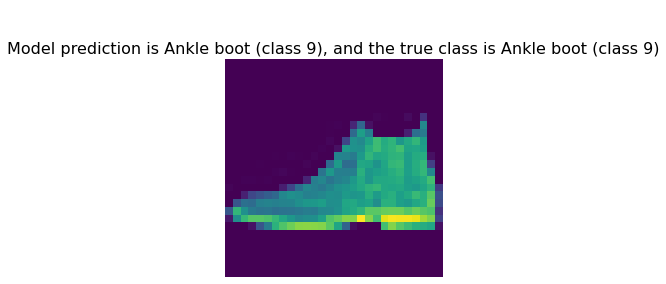

In [ ]:
_do_inference(_HOST, _PORT, _EXAMPLES_FILE,
              _NUM_EXAMPLES, _read_schema(_SCHEMA_FILE))

### What can we achieve with this Fashion MNIST Image Classification pipeline in the real world?
1. Faster Delivery. The pipeline automates the ML process and enables more flexible training and deploying models for data scientists and less maintenance work in terms of underlying data property shifting.
2. Less Risk. A well-build pipeline can allow data scientist to test the model in a timely manner, given that it's either in a pre-production environment or in real world data. Therefore, the model can be tested before spending large amount of time on a model that doesn't capture the essence of statistical properties of the real-world data.
3. Efficiency. The usage for computation and storage resouces become scalable as the pipeline can be simply deployed on cloud.
